In [42]:
from mads_datasets.base import BaseDatastreamer
from mltrainer.preprocessors import BasePreprocessor
from pathlib import Path
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torch import nn
import torch

import sys
sys.path.append('../')
from src import datasets, metrics

In [43]:
trainfile = Path('../data/heart_train.parq').resolve()
testfile = Path('../data/heart_test.parq').resolve()
# trainfile = Path('../data/heart_big_train.parq').resolve()
# testfile = Path('../data/heart_big_test.parq').resolve()
trainfile, testfile

(PosixPath('/home/azureuser/code/mads-exam-24/data/heart_train.parq'),
 PosixPath('/home/azureuser/code/mads-exam-24/data/heart_test.parq'))

Get the 1D data into a 2D matrix

In [44]:
shape = (16, 12)
traindataset = datasets.HeartDataset2D(trainfile, target="target", shape=shape)
testdataset = datasets.HeartDataset2D(testfile, target="target", shape=shape)
traindataset, testdataset
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
    print("Using MPS")
else:
    device = "cpu"

traindataset.to(device)
testdataset.to(device)


Let's see how that works. 
Compare this to the 1D data to see if you understand the transformation.

(torch.Size([1, 16, 12]), tensor(1))

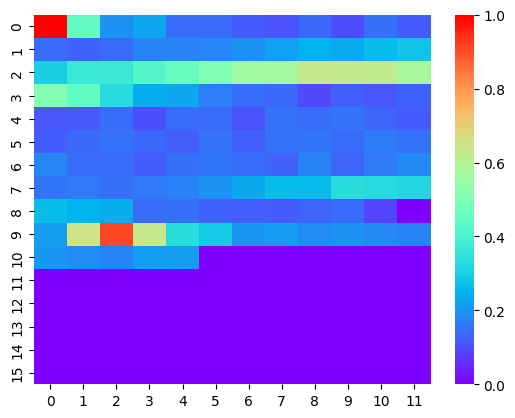

In [45]:
x, y = traindataset[0]
# Assuming your tensor is named 'tensor'
viz = x.squeeze().cpu().numpy()
sns.heatmap(viz, cmap='rainbow')
x.shape, y

Load into a streamer

In [46]:
trainstreamer = BaseDatastreamer(traindataset, preprocessor = BasePreprocessor(), batchsize=32)
teststreamer = BaseDatastreamer(testdataset, preprocessor = BasePreprocessor(), batchsize=32)
len(trainstreamer), len(teststreamer)

(363, 90)

In [47]:
x, y = next(trainstreamer.stream())
x.shape, y.shape

(torch.Size([32, 1, 16, 12]), torch.Size([32]))

The ConvBlock makes it easier to stack block in the model.
Feel free to experiment with other architectures here:
- adding ideas like resnet, googlenet, squeeze-excite, etc.
- add additional layers like dropout, batchnorm, etc.
- experiment with different ways to go from 4D to 2D tensors

In [48]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )
    def forward(self, x):
        return self.conv(x)

In [49]:
import torch
class CNN(nn.Module):
    def __init__(self, config: dict) -> None:
        super().__init__()
        hidden = config['hidden']
        self.convolutions = nn.ModuleList([
            ConvBlock(1, hidden),
        ])

        for i in range(config['num_layers']):
            self.convolutions.extend([ConvBlock(hidden, hidden), nn.ReLU()])
        self.convolutions.append(nn.MaxPool2d(2, 2))

        self.dense = nn.Sequential(
            nn.Flatten(),
            nn.Linear((8*6) * hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, config['num_classes']),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for conv in self.convolutions:
            x = conv(x)
        x = self.dense(x)
        return x

In [52]:
# from src import models
config = {
    'hidden' : 16,
    'num_layers' : 1,
    'num_classes' : 2, # 5 for big dataset
    'shape' : shape,

}
#model = models.CNN(config)
model = CNN(config)
model.to(device)
model(x).shape

torch.Size([32, 2])

In [53]:
yhat = model(x)

The data is unbalanced, so we are interested in much more than just accuracy.

In [54]:
f1micro = metrics.F1Score(average='micro')
f1macro = metrics.F1Score(average='macro')
precision = metrics.Precision('micro')
recall = metrics.Recall('macro')
accuracy = metrics.Accuracy()

In [55]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mads_exam.db")
mlflow.set_experiment("2D conv model")

<Experiment: artifact_location='/home/azureuser/code/mads-exam-24/notebooks/mlruns/1', creation_time=1718732376163, experiment_id='1', last_update_time=1718732376163, lifecycle_stage='active', name='2D conv model', tags={}>

In [56]:
from mltrainer import Trainer, TrainerSettings, ReportTypes
loss_fn = torch.nn.CrossEntropyLoss()

with mlflow.start_run():
    optimizer = torch.optim.Adam
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau

    settings = TrainerSettings(
        epochs=5,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="heart2D",
        train_steps=len(trainstreamer),
        valid_steps=len(teststreamer),
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        scheduler_kwargs={"factor": 0.5, "patience": 5},
        earlystop_kwargs=None
    )

    mlflow.set_tag("model", "Conv2D")
    mlflow.set_tag("dataset", "heart_small_binary")
    mlflow.log_param("scheduler", "None")
    mlflow.log_param("earlystop", "None")

    mlflow.log_params(config)
    mlflow.log_param("epochs", settings.epochs)
    mlflow.log_param("shape0", shape[0])
    mlflow.log_param("optimizer", str(optimizer))
    mlflow.log_params(settings.optimizer_kwargs)

    trainer = Trainer(
        model=model,
        settings=settings,
        loss_fn=loss_fn,
        optimizer=optimizer,
        traindataloader=trainstreamer.stream(),
        validdataloader=teststreamer.stream(),
        scheduler=scheduler,
        )
    trainer.loop()


2024-07-05 09:13:39.046 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to heart2D/20240705-091339
100%|██████████| 363/363 [01:13<00:00,  4.94it/s]
2024-07-05 09:14:58.530 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.4328 test 0.2377 metric ['0.9049', '0.9049', '0.8780', '0.9049', '0.8918', '0.1240']
100%|██████████| 363/363 [01:12<00:00,  5.04it/s]
2024-07-05 09:16:16.940 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.2399 test 0.1693 metric ['0.9233', '0.9233', '0.8977', '0.9233', '0.8854', '0.1115']
100%|██████████| 363/363 [01:12<00:00,  4.98it/s]
2024-07-05 09:17:35.828 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.1941 test 0.1325 metric ['0.9462', '0.9462', '0.9290', '0.9462', '0.9301', '0.0528']
100%|██████████| 363/363 [01:12<00:00,  4.98it/s]
2024-07-05 09:18:54.656 | INFO     | mltrainer.trainer:report:191 - Epoch 3 train 0.1497 test 0.1229 metric ['0.9510', '0.9510', '0.9394', '0.9510', '0.9569', '0.0580']
100%|██████

In [59]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

f1 = f1_score(y, yhat, average = "macro")
ps = precision_score(y, yhat, average = "macro")
rs = recall_score(y, yhat, average = "macro")
ac = accuracy_score(y, yhat)

print(f"f1_score: {f1}")
print(f"precision_score: {ps}")
print(f"recall_score: {rs}")
print(f"accuracy_score: {ac}")

f1_score: 0.9689414200672936
precision_score: 0.965112375406646
recall_score: 0.9729768923214688
accuracy_score: 0.975


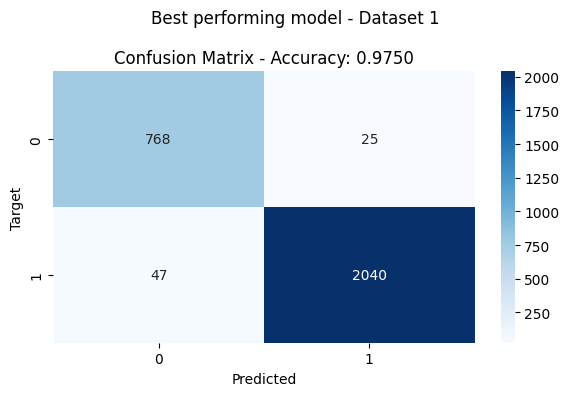

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

y_true = []
y_pred = []

testdata = teststreamer.stream()
for _ in range(len(teststreamer)):
    X, y = next(testdata)
    yhat = model(X)
    yhat = yhat.argmax(dim=1) # we get the one with the highest probability
    y_pred.append(yhat.cpu().tolist())
    y_true.append(y.cpu().tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

cfm = confusion_matrix(y, yhat)
ac = accuracy_score(y, yhat)

# Plotting
plt.figure(figsize=(6, 4))
sns.heatmap(cfm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix - Accuracy: {ac:.4f}")
plt.suptitle("Best performing model - Dataset 1")
plt.xlabel("Predicted")
plt.ylabel("Target")
plt.tight_layout()
plt.savefig("confusion_matrix_small_best_model_5epochs.png")
plt.show()